In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt 
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import date
from wordcloud import WordCloud, STOPWORDS 

In [2]:
# Read chatlog data
chatlog = pd.read_pickle('./data/chatlog.p') 

In [3]:
chatlog

,userId,full_name,message,role,_date,_time
0,2433413723406579,Watsana Kongngoen,สวัสดี,User,2019-11-01,15:23
1,2433413723406579,Watsana Kongngoen,"{'type': 'text', 'text': 'เงินติดล้อสวัสดีครับ'}",Admin,2019-11-01,15:23
2,2433413723406579,Watsana Kongngoen,"{'type': 'quick_reply', 'list_object': [{'text...",Admin,2019-11-01,15:23
3,2433413723406579,Watsana Kongngoen,สวัสดีครับ,User,2019-11-01,16:15
4,2433413723406579,Watsana Kongngoen,"{'type': 'text', 'text': 'เงินติดล้อสวัสดีครับ'}",Admin,2019-11-01,16:15
...,...,...,...,...,...,...
2298575,1379039449007314,None None,สาขา วังไผ่ (ชุมพร) ตรงข้ามบิ๊กซี สาขาชุมพร จ้า,User,2020-05-24,23:56
2298576,1379039449007314,None None,จริงใจพร้อมให้ความช่วยเหลือ รอสักครู่นะจ๊ะ,User,2020-05-24,23:57
2298577,1379039449007314,None None,เอกสารประกอบการยื่นเรื่อง\n1. เล่มทะเบียนรถตัว...,User,2020-05-24,23:58
2298578,1379039449007314,None None,รถปลอดภาระแล้วหรืออยู่ระหว่างผ่อนชำระคับ,User,2020-05-24,23:59


In [4]:
def check_keywords(txt):
    if "toyotavogo" in txt:
        return 1
    else:
        return 0

In [5]:
# Format time to match with the data
today = date.today()
td = today.strftime("%Y-%m-%d")

In [6]:
# Clean the chatlog to have only user conversation on specific date
def clean_chatlog(chatlog, start_date:str=td, end_date:str=td):
    df = chatlog[['userId', 'message', 'role', '_date']] 
    df = df.loc[df.role=='User']
    return df[(df._date >= start_date) & (df._date <= end_date)]

In [7]:
df_new = clean_chatlog(chatlog, start_date='2019-11-01', end_date='2019-11-04')
df_new

,userId,message,role,_date
0,2433413723406579,สวัสดี,User,2019-11-01
3,2433413723406579,สวัสดีครับ,User,2019-11-01
6,2433413723406579,สวัสดีจ้า,User,2019-11-04
9,2433413723406579,ไม่ต้องยุ่งอ่ะ,User,2019-11-04
11,2433413723406579,ไม่ต้องมาคุย,User,2019-11-04
...,...,...,...,...
182231,2765986723444282,ถ้ารถผ่อนมั้ยหมดทีจะได้มั้ยค่ะ,User,2019-11-04
182234,2765986723444282,กุ้ค่ะ,User,2019-11-04
182239,2969967083016774,เปิดรับพนักงานไหมค่ะ,User,2019-11-04
182241,3050730068273826,รถมอไซยังส่งไปหมด,User,2019-11-04


In [8]:
df_new['check'] = df_new.message.apply(lambda x: check_keywords(x))

In [9]:
df_new[df_new['check'] == 1]

,userId,message,role,_date,check


In [10]:
# Utils
def get_th_tokens(text):
#     text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace(',', ' ')
    tokens = word_tokenize(text, engine="newmm", keep_whitespace=False)
    return tokens

In [11]:
# Clean undesired text
def clean_text_1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[.?]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[0-9]{1,10}', '', text)
    text = re.sub('นะ|น่ะ|น่า|น้า','',text)
    text = re.sub('คะ|ค่ะ|ค่า|คระ|คร่ะ|คร๊|ค๊|คร้า','',text)
    text = re.sub('ครับ|คับ|คั้บ|ค้าบ|คัฟ|คร้าบ|คาฟ|ค้าฟ|ฮะ|ฮับ|ฮ้าฟ','',text)
    text = re.sub('จ้า|จ้ะ|จ๊ะ','',text)
    text = re.sub('หน่อย|น่อย','',text)
    text = re.sub('สวัสดี|หวัดดี','',text)
    text = re.sub('ของ','',text)
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    text = re.sub(r'<.?>','', text)
    # ลบ hashtag
    text = re.sub(r'#','',text)
    # ลบ separator เช่น \n \t
    text = ' '.join(text.split())
    text = re.sub('สนใจ','',text)
    text = re.sub('อยากทราบว่า|อยากทราบ','',text)
    text = re.sub('รบกวนสอบถาม|ขอสอบถาม|สอบถาม','',text)
    text = re.sub('ปี','',text)
    text = re.sub('ขอบคุณ','',text)
    text = re.sub('ขอโทษ|ขอโทด','',text)
    text = re.sub('ขอ','',text)
    text = re.sub('ชั้น','',text)
    text = re.sub('เท่าไร|เท่าไหร่|เท่าหรั่ย|เท่าใด|เท่ารัย','',text)
    return text

In [46]:
# def listToString(s):  

#     # Initialize an empty string 
#     str1 = " " 
      
#     return ("".join(s)) 

In [12]:
def remove_digits(text):
    output = re.sub(r'\d+', '', text)
    return output

In [13]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [14]:
# Create new column to store the required string for further process
def clean_text_full(df):
    df = df.groupby(['userId'])['message'].apply(','.join).reset_index()
    df['message'] = df['message'].apply(lambda x: clean_text_1(x))
    df['message'] = df['message'].apply(lambda x: remove_emoji(x))
    df['message'] = df['message'].apply(lambda x: remove_digits(x))
    return df

In [15]:
df_new_clean = clean_text_full(df_new)
df_new_clean

,userId,message
0,1186000531525260,วีออสเท่าใรคั
1,1217179911739736,ป​​ผม​วีโก้​แชมป์​​ประตู​
2,1326518720805322,ออนิว
3,1334390303260358,อยากกรณีจำนำเล่มทะเบียนรถยนต์ ต้องเปนผู้ครอบคร...
4,1343993022391031,
...,...,...
2139,3916518708373650,isuzudmax sxสุรินทร์ ตรีทศกุล
2140,3938375756188118,มอไซยังผ่อนไม่หมด กู้ได้ไหม
2141,4218233651525904,อีซูซุ​d​ max
2142,Ufe1c28d4b7399dce582e6f23c91db3a6,ผมเกี่ยวกับรายละเอียดอัตราดอกเบี้ยรถมอไซค์หนึ่ง


In [51]:
df_new['check'] = df_new.message.apply(lambda x: check_keywords(x))

In [52]:
df_new[df_new['check'] == 1]

,userId,message,role,_date,check


In [18]:
# find top 20 keywords that has the highest TF-IDF average score
def top_20_keywords(df):
    vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(1,2), min_df=2) 
    vectorizer.fit(df['message']) 
    feat_clean = vectorizer.transform(df['message']) 
    feat_clean_array = feat_clean.toarray() 
    avg_tfidf = feat_clean_array.sum(axis=0) / np.count_nonzero(feat_clean_array,axis=0) 
    result_clean = pd.DataFrame() 
    result_clean['word'] = vectorizer.get_feature_names() 
    result_clean['avg_tfidf'] = avg_tfidf 
    return result_clean.sort_values('avg_tfidf', ascending=False).head(20) 

In [16]:
def top_20_keywords_new(df):
    vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(1,2), min_df=2) 
    vectorizer.fit(df['message']) 
    feat_clean = vectorizer.transform(df['message']) 
    feat_clean_array = feat_clean.toarray() 
    avg_tfidf = feat_clean_array.sum(axis=0) / len(df['userId']) 
    result_clean = pd.DataFrame() 
    result_clean['word'] = vectorizer.get_feature_names() 
    result_clean['avg_tfidf'] = avg_tfidf 
    return result_clean.sort_values('avg_tfidf', ascending=False).head(20) 

In [17]:
df_new_new = top_20_keywords_new(df_new_clean)
df_new_new 

,word,avg_tfidf
1464,ประกัน,0.027960
4171,ได้,0.027405
2120,รถ,0.025613
4332,ไม่,0.020200
4407,ไหม,0.020161
452,งวด,0.019417
1650,ผ่อน,0.019130
1946,มี,0.018572
519,จะ,0.017701
1100,ทำ,0.015587


In [19]:
df_new_done = top_20_keywords(df_new_clean)
df_new_done

,word,avg_tfidf
365,คร้,0.834633
1983,มี แล้ว,0.741959
1413,บุคคล,0.728357
114,toyotaavanza,0.692941
2210,รถบรรทุก,0.669318
374,คั,0.637948
36,ge,0.636696
3056,อะไร งวด,0.623134
3293,เฉย,0.614317
2702,สวัสดิ์,0.613503


In [20]:
df_new_done.to_excel('./excel/wc_freq.xlsx')

In [55]:
def gen_text_for_wordcloud(df):
    words = df['word']
    words_to_array = words.tolist()
    return (" ".join(words_to_array))

In [56]:
text = gen_text_for_wordcloud(df_new)
print(text)

คร้ มี แล้ว บุคคล toyotaavanza รถบรรทุก คั ge อะไร งวด เฉย สวัสดิ์ ฟอร์ดเรนเจอร์ เตี้ย almera สุดา วิธี อันนี้ หวัด สินเชื่อ รถมอเตอร์ไซค์ เพาเวอร์ isuzu ประตู


In [57]:
def gen_word_cloud(text):
    path = './font/THSarabunNew.ttf'
    wordcloud = WordCloud(font_path=path, width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10, colormap='coolwarm',regexp = r"[ก-๙a-zA-Z']+", random_state=1).generate(text) 
    # Plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.savefig('./WordCloud/keyword_{}.png'.format(td))
    

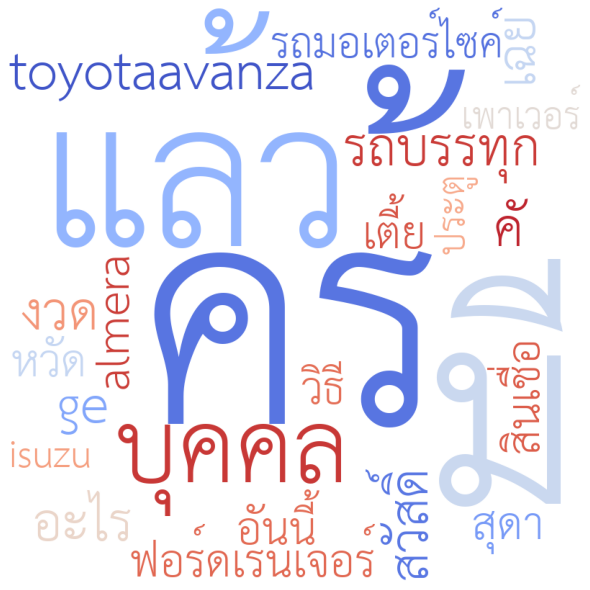

In [58]:
gen_word_cloud(text)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

{'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
(1, 8)
<class 'scipy.sparse.csr.csr_matrix'>
[[1 1 1 1 1 1 1 2]]


In [20]:
submit_to_agent = pd.read_pickle('./data/submit_to_agent.p') 

In [21]:
df_sa = submit_to_agent.loc[submit_to_agent.reason=='not_response'].reset_index()

In [22]:
df_sa_new = df_sa.groupby(['userId'])['message'].apply(','.join).reset_index()

In [24]:
df_sa_new = clean_text_full(df_sa_new)